# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

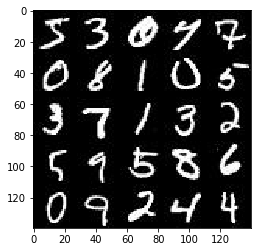

In [5]:
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [6]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

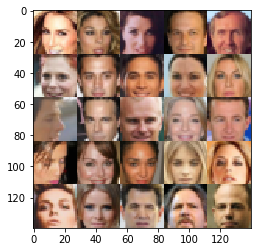

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [20]:
mnist_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
alpha = 0.2
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Create the network
    #real_size = data_shape
    _, width, height, channel = data_shape
    real_input, z_input, lr = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
     
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={real_input:batch_images, z_input:batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_input:batch_images, z_input: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({real_input: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({z_input:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, z_input, channel, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.0966... Generator Loss: 4.2347
Epoch 1/2... Batch 20... Discriminator Loss: 0.1160... Generator Loss: 6.5676
Epoch 1/2... Batch 30... Discriminator Loss: 1.5528... Generator Loss: 0.6913
Epoch 1/2... Batch 40... Discriminator Loss: 0.3780... Generator Loss: 1.9916
Epoch 1/2... Batch 50... Discriminator Loss: 0.7061... Generator Loss: 8.6271
Epoch 1/2... Batch 60... Discriminator Loss: 0.2902... Generator Loss: 2.1377
Epoch 1/2... Batch 70... Discriminator Loss: 1.5384... Generator Loss: 0.6183
Epoch 1/2... Batch 80... Discriminator Loss: 1.6516... Generator Loss: 0.4002
Epoch 1/2... Batch 90... Discriminator Loss: 1.3107... Generator Loss: 2.2780
Epoch 1/2... Batch 100... Discriminator Loss: 0.9582... Generator Loss: 0.7743


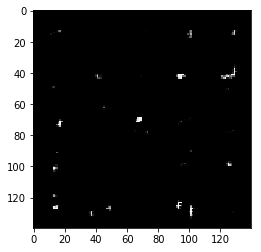

Epoch 1/2... Batch 110... Discriminator Loss: 1.2008... Generator Loss: 2.3926
Epoch 1/2... Batch 120... Discriminator Loss: 0.7509... Generator Loss: 2.0819
Epoch 1/2... Batch 130... Discriminator Loss: 1.3447... Generator Loss: 0.5779
Epoch 1/2... Batch 140... Discriminator Loss: 1.1687... Generator Loss: 0.6858
Epoch 1/2... Batch 150... Discriminator Loss: 1.0535... Generator Loss: 0.6667
Epoch 1/2... Batch 160... Discriminator Loss: 1.7792... Generator Loss: 0.2547
Epoch 1/2... Batch 170... Discriminator Loss: 0.7456... Generator Loss: 1.9439
Epoch 1/2... Batch 180... Discriminator Loss: 1.8806... Generator Loss: 0.2948
Epoch 1/2... Batch 190... Discriminator Loss: 0.5440... Generator Loss: 1.3228
Epoch 1/2... Batch 200... Discriminator Loss: 0.5186... Generator Loss: 1.5441


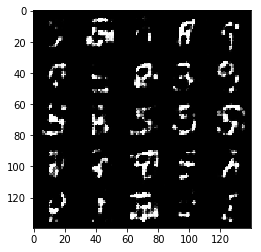

Epoch 1/2... Batch 210... Discriminator Loss: 0.5797... Generator Loss: 1.0997
Epoch 1/2... Batch 220... Discriminator Loss: 2.0136... Generator Loss: 0.2262
Epoch 1/2... Batch 230... Discriminator Loss: 0.6732... Generator Loss: 3.4919
Epoch 1/2... Batch 240... Discriminator Loss: 0.3447... Generator Loss: 3.0156
Epoch 1/2... Batch 250... Discriminator Loss: 0.3188... Generator Loss: 3.1671
Epoch 1/2... Batch 260... Discriminator Loss: 0.3715... Generator Loss: 3.1853
Epoch 1/2... Batch 270... Discriminator Loss: 1.1648... Generator Loss: 0.7563
Epoch 1/2... Batch 280... Discriminator Loss: 2.2668... Generator Loss: 3.3957
Epoch 1/2... Batch 290... Discriminator Loss: 1.0301... Generator Loss: 0.8861
Epoch 1/2... Batch 300... Discriminator Loss: 1.2363... Generator Loss: 0.6575


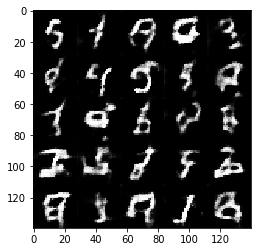

Epoch 1/2... Batch 310... Discriminator Loss: 1.1559... Generator Loss: 0.7008
Epoch 1/2... Batch 320... Discriminator Loss: 0.9193... Generator Loss: 1.4261
Epoch 1/2... Batch 330... Discriminator Loss: 1.0275... Generator Loss: 2.0067
Epoch 1/2... Batch 340... Discriminator Loss: 1.1309... Generator Loss: 1.5524
Epoch 1/2... Batch 350... Discriminator Loss: 1.2736... Generator Loss: 1.8987
Epoch 1/2... Batch 360... Discriminator Loss: 1.0228... Generator Loss: 0.7724
Epoch 1/2... Batch 370... Discriminator Loss: 0.9867... Generator Loss: 1.5424
Epoch 1/2... Batch 380... Discriminator Loss: 0.9600... Generator Loss: 0.9340
Epoch 1/2... Batch 390... Discriminator Loss: 1.1035... Generator Loss: 0.9295
Epoch 1/2... Batch 400... Discriminator Loss: 1.0149... Generator Loss: 1.3276


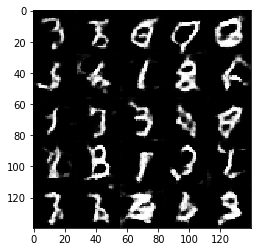

Epoch 1/2... Batch 410... Discriminator Loss: 0.9678... Generator Loss: 1.4704
Epoch 1/2... Batch 420... Discriminator Loss: 1.6012... Generator Loss: 0.3557
Epoch 1/2... Batch 430... Discriminator Loss: 1.1990... Generator Loss: 1.6320
Epoch 1/2... Batch 440... Discriminator Loss: 0.7765... Generator Loss: 1.0495
Epoch 1/2... Batch 450... Discriminator Loss: 1.0109... Generator Loss: 0.8053
Epoch 1/2... Batch 460... Discriminator Loss: 1.1245... Generator Loss: 0.5584
Epoch 2/2... Batch 470... Discriminator Loss: 1.1634... Generator Loss: 1.5024
Epoch 2/2... Batch 480... Discriminator Loss: 1.0751... Generator Loss: 0.8630
Epoch 2/2... Batch 490... Discriminator Loss: 1.1143... Generator Loss: 0.7513
Epoch 2/2... Batch 500... Discriminator Loss: 1.2260... Generator Loss: 0.5850


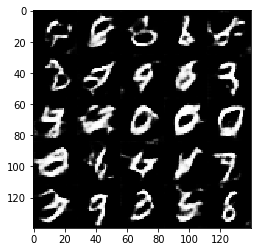

Epoch 2/2... Batch 510... Discriminator Loss: 0.9618... Generator Loss: 0.9527
Epoch 2/2... Batch 520... Discriminator Loss: 1.1342... Generator Loss: 0.7383
Epoch 2/2... Batch 530... Discriminator Loss: 1.3497... Generator Loss: 0.4698
Epoch 2/2... Batch 540... Discriminator Loss: 1.1462... Generator Loss: 0.9109
Epoch 2/2... Batch 550... Discriminator Loss: 1.0290... Generator Loss: 1.1214
Epoch 2/2... Batch 560... Discriminator Loss: 0.8813... Generator Loss: 1.1848
Epoch 2/2... Batch 570... Discriminator Loss: 0.9272... Generator Loss: 1.1187
Epoch 2/2... Batch 580... Discriminator Loss: 1.1823... Generator Loss: 1.9407
Epoch 2/2... Batch 590... Discriminator Loss: 1.2493... Generator Loss: 0.6850
Epoch 2/2... Batch 600... Discriminator Loss: 1.6217... Generator Loss: 0.3152


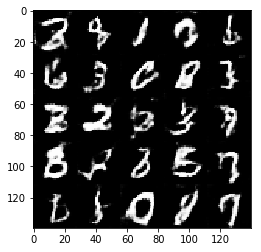

Epoch 2/2... Batch 610... Discriminator Loss: 1.0420... Generator Loss: 0.6695
Epoch 2/2... Batch 620... Discriminator Loss: 1.0596... Generator Loss: 0.6464
Epoch 2/2... Batch 630... Discriminator Loss: 1.1752... Generator Loss: 1.6404
Epoch 2/2... Batch 640... Discriminator Loss: 1.0766... Generator Loss: 0.7584
Epoch 2/2... Batch 650... Discriminator Loss: 0.9545... Generator Loss: 1.4978
Epoch 2/2... Batch 660... Discriminator Loss: 1.6225... Generator Loss: 0.3378
Epoch 2/2... Batch 670... Discriminator Loss: 1.0680... Generator Loss: 1.1321
Epoch 2/2... Batch 680... Discriminator Loss: 1.1925... Generator Loss: 0.5648
Epoch 2/2... Batch 690... Discriminator Loss: 1.1396... Generator Loss: 0.6559
Epoch 2/2... Batch 700... Discriminator Loss: 0.9023... Generator Loss: 1.1835


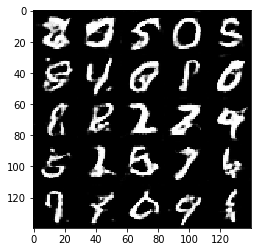

Epoch 2/2... Batch 710... Discriminator Loss: 0.9304... Generator Loss: 1.1338
Epoch 2/2... Batch 720... Discriminator Loss: 0.9665... Generator Loss: 0.9159
Epoch 2/2... Batch 730... Discriminator Loss: 1.1392... Generator Loss: 0.6657
Epoch 2/2... Batch 740... Discriminator Loss: 0.9986... Generator Loss: 1.6720
Epoch 2/2... Batch 750... Discriminator Loss: 1.0043... Generator Loss: 0.8056
Epoch 2/2... Batch 760... Discriminator Loss: 1.2735... Generator Loss: 0.4759
Epoch 2/2... Batch 770... Discriminator Loss: 0.9794... Generator Loss: 1.2524
Epoch 2/2... Batch 780... Discriminator Loss: 1.0470... Generator Loss: 1.1485
Epoch 2/2... Batch 790... Discriminator Loss: 1.0080... Generator Loss: 0.8343
Epoch 2/2... Batch 800... Discriminator Loss: 0.8951... Generator Loss: 1.0729


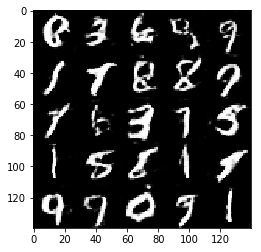

Epoch 2/2... Batch 810... Discriminator Loss: 1.0588... Generator Loss: 0.7594
Epoch 2/2... Batch 820... Discriminator Loss: 0.6326... Generator Loss: 1.3635
Epoch 2/2... Batch 830... Discriminator Loss: 0.9500... Generator Loss: 0.8011
Epoch 2/2... Batch 840... Discriminator Loss: 0.8586... Generator Loss: 2.0270
Epoch 2/2... Batch 850... Discriminator Loss: 0.9407... Generator Loss: 0.7534
Epoch 2/2... Batch 860... Discriminator Loss: 0.8256... Generator Loss: 0.9714
Epoch 2/2... Batch 870... Discriminator Loss: 1.1140... Generator Loss: 0.8268
Epoch 2/2... Batch 880... Discriminator Loss: 1.1655... Generator Loss: 0.6041
Epoch 2/2... Batch 890... Discriminator Loss: 1.0795... Generator Loss: 2.3315
Epoch 2/2... Batch 900... Discriminator Loss: 0.9587... Generator Loss: 0.8585


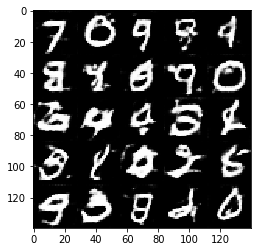

Epoch 2/2... Batch 910... Discriminator Loss: 1.4948... Generator Loss: 0.3992
Epoch 2/2... Batch 920... Discriminator Loss: 1.1265... Generator Loss: 1.3750
Epoch 2/2... Batch 930... Discriminator Loss: 0.8796... Generator Loss: 1.0312


In [18]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5
ALPHA = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Batch 10... Discriminator Loss: 1.5790... Generator Loss: 0.4233
Epoch 1/2... Batch 20... Discriminator Loss: 0.8956... Generator Loss: 0.8932
Epoch 1/2... Batch 30... Discriminator Loss: 0.2947... Generator Loss: 1.9588
Epoch 1/2... Batch 40... Discriminator Loss: 0.9866... Generator Loss: 0.7078
Epoch 1/2... Batch 50... Discriminator Loss: 1.3037... Generator Loss: 0.5091
Epoch 1/2... Batch 60... Discriminator Loss: 1.4963... Generator Loss: 0.6900
Epoch 1/2... Batch 70... Discriminator Loss: 1.2884... Generator Loss: 0.9876
Epoch 1/2... Batch 80... Discriminator Loss: 1.4356... Generator Loss: 1.3255
Epoch 1/2... Batch 90... Discriminator Loss: 1.3272... Generator Loss: 0.8595
Epoch 1/2... Batch 100... Discriminator Loss: 1.1742... Generator Loss: 0.6952


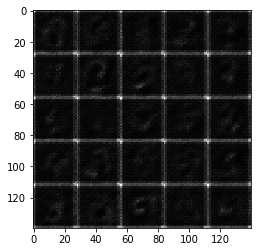

Epoch 1/2... Batch 110... Discriminator Loss: 1.5347... Generator Loss: 1.4862
Epoch 1/2... Batch 120... Discriminator Loss: 1.4609... Generator Loss: 1.2541
Epoch 1/2... Batch 130... Discriminator Loss: 1.2357... Generator Loss: 0.6397
Epoch 1/2... Batch 140... Discriminator Loss: 1.2181... Generator Loss: 0.6128
Epoch 1/2... Batch 150... Discriminator Loss: 1.2848... Generator Loss: 0.5536
Epoch 1/2... Batch 160... Discriminator Loss: 1.2233... Generator Loss: 1.0181
Epoch 1/2... Batch 170... Discriminator Loss: 1.0533... Generator Loss: 0.7707
Epoch 1/2... Batch 180... Discriminator Loss: 1.1242... Generator Loss: 0.6358
Epoch 1/2... Batch 190... Discriminator Loss: 0.9420... Generator Loss: 0.8405
Epoch 1/2... Batch 200... Discriminator Loss: 0.9795... Generator Loss: 0.9428


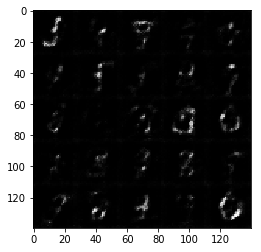

Epoch 1/2... Batch 210... Discriminator Loss: 0.9369... Generator Loss: 1.4116
Epoch 1/2... Batch 220... Discriminator Loss: 0.9347... Generator Loss: 0.9340
Epoch 1/2... Batch 230... Discriminator Loss: 1.0516... Generator Loss: 0.6637
Epoch 1/2... Batch 240... Discriminator Loss: 0.7838... Generator Loss: 1.1987
Epoch 1/2... Batch 250... Discriminator Loss: 1.0118... Generator Loss: 1.7203
Epoch 1/2... Batch 260... Discriminator Loss: 0.9896... Generator Loss: 0.6779
Epoch 1/2... Batch 270... Discriminator Loss: 0.6940... Generator Loss: 1.3392
Epoch 1/2... Batch 280... Discriminator Loss: 1.0980... Generator Loss: 0.5929
Epoch 1/2... Batch 290... Discriminator Loss: 0.7674... Generator Loss: 1.4643
Epoch 1/2... Batch 300... Discriminator Loss: 0.7903... Generator Loss: 1.5221


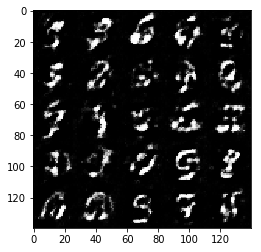

Epoch 1/2... Batch 310... Discriminator Loss: 0.7298... Generator Loss: 1.0023
Epoch 1/2... Batch 320... Discriminator Loss: 0.9392... Generator Loss: 2.4089
Epoch 1/2... Batch 330... Discriminator Loss: 0.7597... Generator Loss: 2.5219
Epoch 1/2... Batch 340... Discriminator Loss: 0.7623... Generator Loss: 1.5367
Epoch 1/2... Batch 350... Discriminator Loss: 0.6718... Generator Loss: 1.2926
Epoch 1/2... Batch 360... Discriminator Loss: 0.6739... Generator Loss: 1.3498
Epoch 1/2... Batch 370... Discriminator Loss: 0.6432... Generator Loss: 1.9671
Epoch 1/2... Batch 380... Discriminator Loss: 0.7211... Generator Loss: 1.0363
Epoch 1/2... Batch 390... Discriminator Loss: 0.8609... Generator Loss: 0.7823
Epoch 1/2... Batch 400... Discriminator Loss: 0.6645... Generator Loss: 0.9860


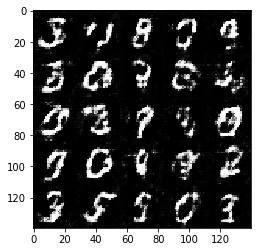

Epoch 1/2... Batch 410... Discriminator Loss: 0.6971... Generator Loss: 1.4063
Epoch 1/2... Batch 420... Discriminator Loss: 1.4118... Generator Loss: 0.3591
Epoch 1/2... Batch 430... Discriminator Loss: 0.7829... Generator Loss: 1.3967
Epoch 1/2... Batch 440... Discriminator Loss: 0.8726... Generator Loss: 0.7878
Epoch 1/2... Batch 450... Discriminator Loss: 0.8727... Generator Loss: 1.7268
Epoch 1/2... Batch 460... Discriminator Loss: 0.8393... Generator Loss: 0.9822
Epoch 2/2... Batch 470... Discriminator Loss: 1.0240... Generator Loss: 1.1018
Epoch 2/2... Batch 480... Discriminator Loss: 0.7866... Generator Loss: 0.9541
Epoch 2/2... Batch 490... Discriminator Loss: 1.0390... Generator Loss: 0.6534
Epoch 2/2... Batch 500... Discriminator Loss: 1.0333... Generator Loss: 0.9561


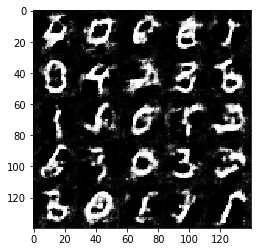

Epoch 2/2... Batch 510... Discriminator Loss: 0.6787... Generator Loss: 1.5216
Epoch 2/2... Batch 520... Discriminator Loss: 0.9809... Generator Loss: 1.2549
Epoch 2/2... Batch 530... Discriminator Loss: 1.0229... Generator Loss: 0.6984
Epoch 2/2... Batch 540... Discriminator Loss: 1.1846... Generator Loss: 0.5022
Epoch 2/2... Batch 550... Discriminator Loss: 1.0336... Generator Loss: 1.5435
Epoch 2/2... Batch 560... Discriminator Loss: 0.9093... Generator Loss: 1.3610
Epoch 2/2... Batch 570... Discriminator Loss: 0.9305... Generator Loss: 0.9984
Epoch 2/2... Batch 580... Discriminator Loss: 1.1796... Generator Loss: 1.8294
Epoch 2/2... Batch 590... Discriminator Loss: 1.1766... Generator Loss: 0.8753
Epoch 2/2... Batch 600... Discriminator Loss: 1.0443... Generator Loss: 0.6432


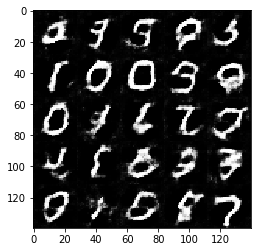

Epoch 2/2... Batch 610... Discriminator Loss: 0.9317... Generator Loss: 0.9469
Epoch 2/2... Batch 620... Discriminator Loss: 0.8752... Generator Loss: 1.1259
Epoch 2/2... Batch 630... Discriminator Loss: 1.0846... Generator Loss: 1.2718
Epoch 2/2... Batch 640... Discriminator Loss: 0.9622... Generator Loss: 0.8397
Epoch 2/2... Batch 650... Discriminator Loss: 1.1148... Generator Loss: 1.3888
Epoch 2/2... Batch 660... Discriminator Loss: 1.3260... Generator Loss: 0.4463
Epoch 2/2... Batch 670... Discriminator Loss: 1.0788... Generator Loss: 1.5623
Epoch 2/2... Batch 680... Discriminator Loss: 1.0031... Generator Loss: 0.9370
Epoch 2/2... Batch 690... Discriminator Loss: 0.8621... Generator Loss: 0.9167
Epoch 2/2... Batch 700... Discriminator Loss: 1.0712... Generator Loss: 0.8009


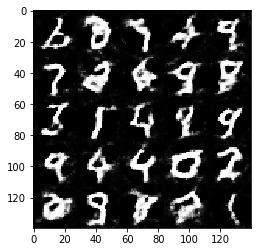

Epoch 2/2... Batch 710... Discriminator Loss: 1.0611... Generator Loss: 0.8605
Epoch 2/2... Batch 720... Discriminator Loss: 0.8762... Generator Loss: 0.9562
Epoch 2/2... Batch 730... Discriminator Loss: 1.1484... Generator Loss: 1.4378
Epoch 2/2... Batch 740... Discriminator Loss: 0.9200... Generator Loss: 1.0720
Epoch 2/2... Batch 750... Discriminator Loss: 0.9641... Generator Loss: 1.0458
Epoch 2/2... Batch 760... Discriminator Loss: 0.9855... Generator Loss: 0.9309
Epoch 2/2... Batch 770... Discriminator Loss: 1.1906... Generator Loss: 1.7741
Epoch 2/2... Batch 780... Discriminator Loss: 1.0714... Generator Loss: 1.2124
Epoch 2/2... Batch 790... Discriminator Loss: 1.1130... Generator Loss: 0.6058
Epoch 2/2... Batch 800... Discriminator Loss: 0.9985... Generator Loss: 0.9566


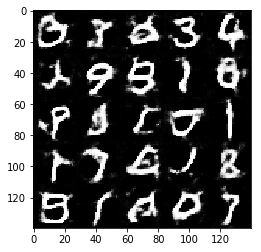

Epoch 2/2... Batch 810... Discriminator Loss: 0.8990... Generator Loss: 0.8596
Epoch 2/2... Batch 820... Discriminator Loss: 1.1048... Generator Loss: 1.5686
Epoch 2/2... Batch 830... Discriminator Loss: 0.9718... Generator Loss: 0.7583
Epoch 2/2... Batch 840... Discriminator Loss: 1.0256... Generator Loss: 1.5063
Epoch 2/2... Batch 850... Discriminator Loss: 1.2338... Generator Loss: 0.4901
Epoch 2/2... Batch 860... Discriminator Loss: 1.0552... Generator Loss: 0.7011
Epoch 2/2... Batch 870... Discriminator Loss: 1.0729... Generator Loss: 0.6837
Epoch 2/2... Batch 880... Discriminator Loss: 0.9413... Generator Loss: 1.1616
Epoch 2/2... Batch 890... Discriminator Loss: 1.1663... Generator Loss: 1.8076
Epoch 2/2... Batch 900... Discriminator Loss: 0.9550... Generator Loss: 1.2290


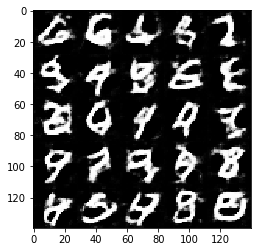

Epoch 2/2... Batch 910... Discriminator Loss: 1.4589... Generator Loss: 0.3745
Epoch 2/2... Batch 920... Discriminator Loss: 0.9832... Generator Loss: 1.2324
Epoch 2/2... Batch 930... Discriminator Loss: 0.9867... Generator Loss: 0.7416


In [21]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.4729... Generator Loss: 0.9438
Epoch 1/1... Batch 20... Discriminator Loss: 0.2548... Generator Loss: 7.2764
Epoch 1/1... Batch 30... Discriminator Loss: 0.0909... Generator Loss: 6.7448
Epoch 1/1... Batch 40... Discriminator Loss: 0.1644... Generator Loss: 3.6846
Epoch 1/1... Batch 50... Discriminator Loss: 0.5316... Generator Loss: 2.8316
Epoch 1/1... Batch 60... Discriminator Loss: 0.6241... Generator Loss: 4.3842
Epoch 1/1... Batch 70... Discriminator Loss: 2.8927... Generator Loss: 9.2388
Epoch 1/1... Batch 80... Discriminator Loss: 0.2593... Generator Loss: 2.4080
Epoch 1/1... Batch 90... Discriminator Loss: 0.2274... Generator Loss: 2.3860
Epoch 1/1... Batch 100... Discriminator Loss: 2.0625... Generator Loss: 5.2277


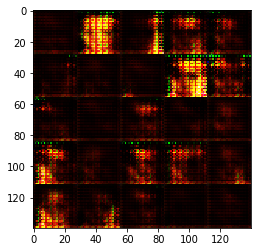

Epoch 1/1... Batch 110... Discriminator Loss: 0.9242... Generator Loss: 2.1293
Epoch 1/1... Batch 120... Discriminator Loss: 0.3914... Generator Loss: 2.3702
Epoch 1/1... Batch 130... Discriminator Loss: 0.4187... Generator Loss: 1.8700
Epoch 1/1... Batch 140... Discriminator Loss: 1.3521... Generator Loss: 0.5934
Epoch 1/1... Batch 150... Discriminator Loss: 4.1772... Generator Loss: 0.0497
Epoch 1/1... Batch 160... Discriminator Loss: 0.7874... Generator Loss: 1.0893
Epoch 1/1... Batch 170... Discriminator Loss: 2.5797... Generator Loss: 3.9692
Epoch 1/1... Batch 180... Discriminator Loss: 0.9904... Generator Loss: 0.9580
Epoch 1/1... Batch 190... Discriminator Loss: 1.2612... Generator Loss: 0.8471
Epoch 1/1... Batch 200... Discriminator Loss: 0.8045... Generator Loss: 1.4766


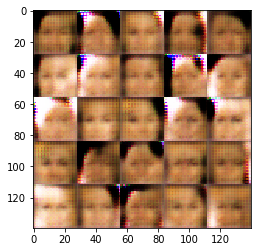

Epoch 1/1... Batch 210... Discriminator Loss: 3.2388... Generator Loss: 4.2535
Epoch 1/1... Batch 220... Discriminator Loss: 1.1458... Generator Loss: 0.8255
Epoch 1/1... Batch 230... Discriminator Loss: 1.1765... Generator Loss: 2.3878
Epoch 1/1... Batch 240... Discriminator Loss: 1.8336... Generator Loss: 0.2398
Epoch 1/1... Batch 250... Discriminator Loss: 1.2027... Generator Loss: 0.7313
Epoch 1/1... Batch 260... Discriminator Loss: 1.1409... Generator Loss: 0.6257
Epoch 1/1... Batch 270... Discriminator Loss: 1.1242... Generator Loss: 0.9335
Epoch 1/1... Batch 280... Discriminator Loss: 1.2596... Generator Loss: 0.7909
Epoch 1/1... Batch 290... Discriminator Loss: 1.3749... Generator Loss: 1.8434
Epoch 1/1... Batch 300... Discriminator Loss: 1.3298... Generator Loss: 1.0095


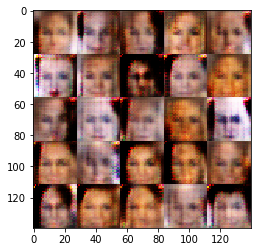

Epoch 1/1... Batch 310... Discriminator Loss: 1.2099... Generator Loss: 0.9483
Epoch 1/1... Batch 320... Discriminator Loss: 1.1925... Generator Loss: 1.2315
Epoch 1/1... Batch 330... Discriminator Loss: 1.3072... Generator Loss: 0.4526
Epoch 1/1... Batch 340... Discriminator Loss: 1.2760... Generator Loss: 0.6819
Epoch 1/1... Batch 350... Discriminator Loss: 1.8083... Generator Loss: 0.2557
Epoch 1/1... Batch 360... Discriminator Loss: 0.7934... Generator Loss: 1.1336
Epoch 1/1... Batch 370... Discriminator Loss: 0.7784... Generator Loss: 1.5092
Epoch 1/1... Batch 380... Discriminator Loss: 1.1095... Generator Loss: 0.6098
Epoch 1/1... Batch 390... Discriminator Loss: 1.1326... Generator Loss: 1.3753
Epoch 1/1... Batch 400... Discriminator Loss: 1.1218... Generator Loss: 0.7048


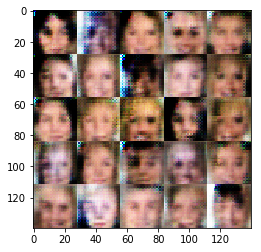

Epoch 1/1... Batch 410... Discriminator Loss: 1.6035... Generator Loss: 0.3745
Epoch 1/1... Batch 420... Discriminator Loss: 1.4722... Generator Loss: 1.2150
Epoch 1/1... Batch 430... Discriminator Loss: 1.4254... Generator Loss: 0.4563
Epoch 1/1... Batch 440... Discriminator Loss: 1.4673... Generator Loss: 1.1774
Epoch 1/1... Batch 450... Discriminator Loss: 1.1814... Generator Loss: 1.2404
Epoch 1/1... Batch 460... Discriminator Loss: 1.2736... Generator Loss: 0.7048
Epoch 1/1... Batch 470... Discriminator Loss: 1.1732... Generator Loss: 0.8441
Epoch 1/1... Batch 480... Discriminator Loss: 1.4605... Generator Loss: 0.6650
Epoch 1/1... Batch 490... Discriminator Loss: 1.2919... Generator Loss: 0.8689
Epoch 1/1... Batch 500... Discriminator Loss: 1.1074... Generator Loss: 0.9344


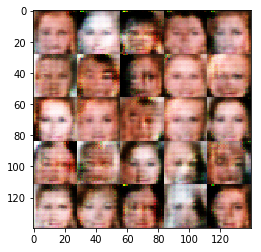

Epoch 1/1... Batch 510... Discriminator Loss: 1.3794... Generator Loss: 0.6866
Epoch 1/1... Batch 520... Discriminator Loss: 1.3077... Generator Loss: 1.3945
Epoch 1/1... Batch 530... Discriminator Loss: 1.0840... Generator Loss: 0.6397
Epoch 1/1... Batch 540... Discriminator Loss: 1.2377... Generator Loss: 0.6703
Epoch 1/1... Batch 550... Discriminator Loss: 0.8564... Generator Loss: 1.0792
Epoch 1/1... Batch 560... Discriminator Loss: 2.0043... Generator Loss: 0.2387
Epoch 1/1... Batch 570... Discriminator Loss: 1.2415... Generator Loss: 0.7870
Epoch 1/1... Batch 580... Discriminator Loss: 1.4163... Generator Loss: 0.7377
Epoch 1/1... Batch 590... Discriminator Loss: 1.3814... Generator Loss: 0.7320
Epoch 1/1... Batch 600... Discriminator Loss: 1.3501... Generator Loss: 0.7355


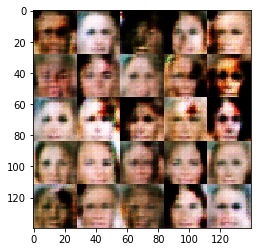

Epoch 1/1... Batch 610... Discriminator Loss: 1.4285... Generator Loss: 0.7544
Epoch 1/1... Batch 620... Discriminator Loss: 1.2863... Generator Loss: 0.7031
Epoch 1/1... Batch 630... Discriminator Loss: 1.5293... Generator Loss: 0.6941
Epoch 1/1... Batch 640... Discriminator Loss: 1.4528... Generator Loss: 0.6581
Epoch 1/1... Batch 650... Discriminator Loss: 1.4437... Generator Loss: 0.6674
Epoch 1/1... Batch 660... Discriminator Loss: 1.1630... Generator Loss: 0.8653
Epoch 1/1... Batch 670... Discriminator Loss: 1.2378... Generator Loss: 0.9556
Epoch 1/1... Batch 680... Discriminator Loss: 1.1288... Generator Loss: 0.6759
Epoch 1/1... Batch 690... Discriminator Loss: 1.1708... Generator Loss: 1.2363
Epoch 1/1... Batch 700... Discriminator Loss: 1.2202... Generator Loss: 0.7489


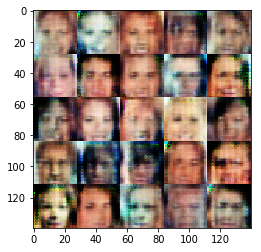

Epoch 1/1... Batch 710... Discriminator Loss: 1.4236... Generator Loss: 1.1113
Epoch 1/1... Batch 720... Discriminator Loss: 1.3235... Generator Loss: 0.7080
Epoch 1/1... Batch 730... Discriminator Loss: 1.2238... Generator Loss: 0.5394
Epoch 1/1... Batch 740... Discriminator Loss: 1.0243... Generator Loss: 0.8724
Epoch 1/1... Batch 750... Discriminator Loss: 1.4112... Generator Loss: 0.7667
Epoch 1/1... Batch 760... Discriminator Loss: 1.2085... Generator Loss: 0.7496
Epoch 1/1... Batch 770... Discriminator Loss: 1.1913... Generator Loss: 0.9266
Epoch 1/1... Batch 780... Discriminator Loss: 1.9008... Generator Loss: 2.1025
Epoch 1/1... Batch 790... Discriminator Loss: 1.3000... Generator Loss: 1.5581
Epoch 1/1... Batch 800... Discriminator Loss: 1.1799... Generator Loss: 0.9564


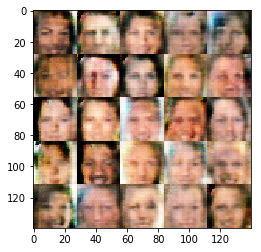

Epoch 1/1... Batch 810... Discriminator Loss: 1.1509... Generator Loss: 0.8068
Epoch 1/1... Batch 820... Discriminator Loss: 1.2291... Generator Loss: 0.8105
Epoch 1/1... Batch 830... Discriminator Loss: 1.4530... Generator Loss: 0.5271
Epoch 1/1... Batch 840... Discriminator Loss: 1.1803... Generator Loss: 0.7268
Epoch 1/1... Batch 850... Discriminator Loss: 1.3287... Generator Loss: 0.9898
Epoch 1/1... Batch 860... Discriminator Loss: 1.4446... Generator Loss: 0.7209
Epoch 1/1... Batch 870... Discriminator Loss: 1.1034... Generator Loss: 0.9434
Epoch 1/1... Batch 880... Discriminator Loss: 1.2328... Generator Loss: 0.9454
Epoch 1/1... Batch 890... Discriminator Loss: 1.3247... Generator Loss: 0.6018
Epoch 1/1... Batch 900... Discriminator Loss: 1.3190... Generator Loss: 0.6859


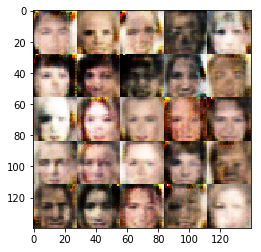

Epoch 1/1... Batch 910... Discriminator Loss: 1.1709... Generator Loss: 0.8390
Epoch 1/1... Batch 920... Discriminator Loss: 2.0309... Generator Loss: 1.9504
Epoch 1/1... Batch 930... Discriminator Loss: 1.0031... Generator Loss: 0.9675
Epoch 1/1... Batch 940... Discriminator Loss: 0.6631... Generator Loss: 1.2237
Epoch 1/1... Batch 950... Discriminator Loss: 1.1302... Generator Loss: 1.1427
Epoch 1/1... Batch 960... Discriminator Loss: 1.6681... Generator Loss: 0.6259
Epoch 1/1... Batch 970... Discriminator Loss: 1.1697... Generator Loss: 0.9989
Epoch 1/1... Batch 980... Discriminator Loss: 1.2305... Generator Loss: 0.7695
Epoch 1/1... Batch 990... Discriminator Loss: 1.4717... Generator Loss: 0.7156
Epoch 1/1... Batch 1000... Discriminator Loss: 1.5069... Generator Loss: 0.6488


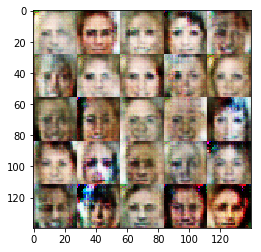

Epoch 1/1... Batch 1010... Discriminator Loss: 1.2906... Generator Loss: 0.7680
Epoch 1/1... Batch 1020... Discriminator Loss: 1.4859... Generator Loss: 0.7003
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3677... Generator Loss: 0.6736
Epoch 1/1... Batch 1040... Discriminator Loss: 1.4381... Generator Loss: 0.6810
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4889... Generator Loss: 0.5913
Epoch 1/1... Batch 1060... Discriminator Loss: 1.4260... Generator Loss: 0.6837
Epoch 1/1... Batch 1070... Discriminator Loss: 1.1700... Generator Loss: 0.7654
Epoch 1/1... Batch 1080... Discriminator Loss: 1.5698... Generator Loss: 0.8013
Epoch 1/1... Batch 1090... Discriminator Loss: 1.3607... Generator Loss: 0.7346
Epoch 1/1... Batch 1100... Discriminator Loss: 1.5491... Generator Loss: 0.6643


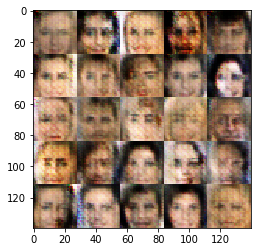

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2701... Generator Loss: 0.6640
Epoch 1/1... Batch 1120... Discriminator Loss: 1.4504... Generator Loss: 0.7294
Epoch 1/1... Batch 1130... Discriminator Loss: 1.3603... Generator Loss: 0.6341
Epoch 1/1... Batch 1140... Discriminator Loss: 1.4082... Generator Loss: 0.5851
Epoch 1/1... Batch 1150... Discriminator Loss: 1.4461... Generator Loss: 0.7559
Epoch 1/1... Batch 1160... Discriminator Loss: 1.1300... Generator Loss: 0.9246
Epoch 1/1... Batch 1170... Discriminator Loss: 1.2510... Generator Loss: 0.5684
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2095... Generator Loss: 0.8948
Epoch 1/1... Batch 1190... Discriminator Loss: 1.7328... Generator Loss: 1.5684
Epoch 1/1... Batch 1200... Discriminator Loss: 1.1779... Generator Loss: 1.3281


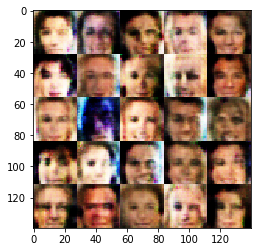

Epoch 1/1... Batch 1210... Discriminator Loss: 1.2245... Generator Loss: 0.7918
Epoch 1/1... Batch 1220... Discriminator Loss: 1.2583... Generator Loss: 0.6736
Epoch 1/1... Batch 1230... Discriminator Loss: 1.3888... Generator Loss: 1.4231
Epoch 1/1... Batch 1240... Discriminator Loss: 1.3625... Generator Loss: 0.5939
Epoch 1/1... Batch 1250... Discriminator Loss: 1.2615... Generator Loss: 0.8935
Epoch 1/1... Batch 1260... Discriminator Loss: 1.1733... Generator Loss: 0.8646
Epoch 1/1... Batch 1270... Discriminator Loss: 1.1613... Generator Loss: 1.1567
Epoch 1/1... Batch 1280... Discriminator Loss: 1.2863... Generator Loss: 0.9132
Epoch 1/1... Batch 1290... Discriminator Loss: 1.1544... Generator Loss: 1.2854
Epoch 1/1... Batch 1300... Discriminator Loss: 1.3196... Generator Loss: 0.8024


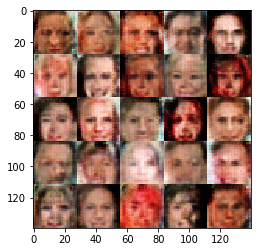

Epoch 1/1... Batch 1310... Discriminator Loss: 1.5076... Generator Loss: 1.7711
Epoch 1/1... Batch 1320... Discriminator Loss: 1.3053... Generator Loss: 0.5853
Epoch 1/1... Batch 1330... Discriminator Loss: 1.3994... Generator Loss: 1.0374
Epoch 1/1... Batch 1340... Discriminator Loss: 1.2734... Generator Loss: 1.1701
Epoch 1/1... Batch 1350... Discriminator Loss: 1.1694... Generator Loss: 0.9414
Epoch 1/1... Batch 1360... Discriminator Loss: 1.8742... Generator Loss: 1.8535
Epoch 1/1... Batch 1370... Discriminator Loss: 1.4060... Generator Loss: 0.4126
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2764... Generator Loss: 1.0115
Epoch 1/1... Batch 1390... Discriminator Loss: 1.1976... Generator Loss: 1.0276
Epoch 1/1... Batch 1400... Discriminator Loss: 1.4859... Generator Loss: 1.0799


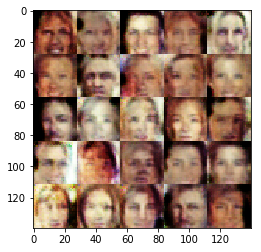

Epoch 1/1... Batch 1410... Discriminator Loss: 1.2569... Generator Loss: 0.8658
Epoch 1/1... Batch 1420... Discriminator Loss: 1.4689... Generator Loss: 1.4218
Epoch 1/1... Batch 1430... Discriminator Loss: 1.3410... Generator Loss: 0.7227
Epoch 1/1... Batch 1440... Discriminator Loss: 1.5553... Generator Loss: 0.4419
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3571... Generator Loss: 0.4927
Epoch 1/1... Batch 1460... Discriminator Loss: 1.4249... Generator Loss: 0.5281
Epoch 1/1... Batch 1470... Discriminator Loss: 1.3017... Generator Loss: 0.7536
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1811... Generator Loss: 0.7491
Epoch 1/1... Batch 1490... Discriminator Loss: 1.1224... Generator Loss: 0.7068
Epoch 1/1... Batch 1500... Discriminator Loss: 1.3488... Generator Loss: 0.6868


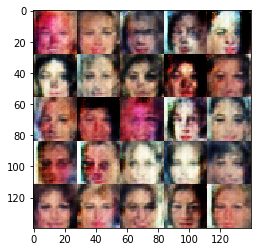

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2529... Generator Loss: 0.7291
Epoch 1/1... Batch 1520... Discriminator Loss: 1.5548... Generator Loss: 0.7838
Epoch 1/1... Batch 1530... Discriminator Loss: 1.5709... Generator Loss: 0.3631
Epoch 1/1... Batch 1540... Discriminator Loss: 1.3075... Generator Loss: 0.9917
Epoch 1/1... Batch 1550... Discriminator Loss: 1.3775... Generator Loss: 0.7068
Epoch 1/1... Batch 1560... Discriminator Loss: 1.3472... Generator Loss: 0.6040
Epoch 1/1... Batch 1570... Discriminator Loss: 1.2710... Generator Loss: 1.2626
Epoch 1/1... Batch 1580... Discriminator Loss: 1.3039... Generator Loss: 0.9427


In [19]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Batch 10... Discriminator Loss: 1.4762... Generator Loss: 0.4677
Epoch 1/1... Batch 20... Discriminator Loss: 0.8907... Generator Loss: 0.8615
Epoch 1/1... Batch 30... Discriminator Loss: 0.8061... Generator Loss: 1.3364
Epoch 1/1... Batch 40... Discriminator Loss: 0.8211... Generator Loss: 1.7414
Epoch 1/1... Batch 50... Discriminator Loss: 0.9792... Generator Loss: 1.5657
Epoch 1/1... Batch 60... Discriminator Loss: 1.5098... Generator Loss: 0.3549
Epoch 1/1... Batch 70... Discriminator Loss: 1.2388... Generator Loss: 0.5734
Epoch 1/1... Batch 80... Discriminator Loss: 1.1726... Generator Loss: 0.5611
Epoch 1/1... Batch 90... Discriminator Loss: 1.0855... Generator Loss: 1.2576
Epoch 1/1... Batch 100... Discriminator Loss: 0.7147... Generator Loss: 1.4031


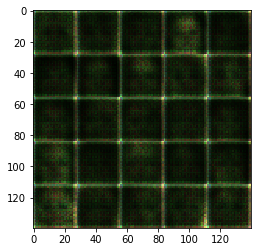

Epoch 1/1... Batch 110... Discriminator Loss: 1.3169... Generator Loss: 0.4595
Epoch 1/1... Batch 120... Discriminator Loss: 0.8760... Generator Loss: 0.9574
Epoch 1/1... Batch 130... Discriminator Loss: 0.9155... Generator Loss: 1.1503
Epoch 1/1... Batch 140... Discriminator Loss: 0.8362... Generator Loss: 1.1859
Epoch 1/1... Batch 150... Discriminator Loss: 1.0918... Generator Loss: 0.6438
Epoch 1/1... Batch 160... Discriminator Loss: 1.3391... Generator Loss: 0.4506
Epoch 1/1... Batch 170... Discriminator Loss: 0.7793... Generator Loss: 1.2544
Epoch 1/1... Batch 180... Discriminator Loss: 0.7927... Generator Loss: 1.4619
Epoch 1/1... Batch 190... Discriminator Loss: 0.8776... Generator Loss: 2.2019
Epoch 1/1... Batch 200... Discriminator Loss: 1.2032... Generator Loss: 0.5470


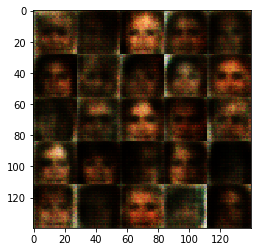

Epoch 1/1... Batch 210... Discriminator Loss: 1.3902... Generator Loss: 0.4570
Epoch 1/1... Batch 220... Discriminator Loss: 0.8222... Generator Loss: 0.8693
Epoch 1/1... Batch 230... Discriminator Loss: 0.7434... Generator Loss: 1.6561
Epoch 1/1... Batch 240... Discriminator Loss: 0.8246... Generator Loss: 1.0056
Epoch 1/1... Batch 250... Discriminator Loss: 1.0061... Generator Loss: 0.7237
Epoch 1/1... Batch 260... Discriminator Loss: 0.7338... Generator Loss: 1.1728
Epoch 1/1... Batch 270... Discriminator Loss: 0.4116... Generator Loss: 2.3400
Epoch 1/1... Batch 280... Discriminator Loss: 1.0441... Generator Loss: 1.6687
Epoch 1/1... Batch 290... Discriminator Loss: 0.2997... Generator Loss: 2.7845
Epoch 1/1... Batch 300... Discriminator Loss: 1.0576... Generator Loss: 0.6006


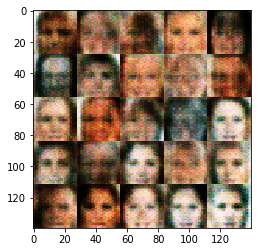

Epoch 1/1... Batch 310... Discriminator Loss: 0.4205... Generator Loss: 2.5303
Epoch 1/1... Batch 320... Discriminator Loss: 0.6605... Generator Loss: 1.3233
Epoch 1/1... Batch 330... Discriminator Loss: 0.9349... Generator Loss: 0.7098
Epoch 1/1... Batch 340... Discriminator Loss: 0.5732... Generator Loss: 1.3107
Epoch 1/1... Batch 350... Discriminator Loss: 1.1302... Generator Loss: 2.1854
Epoch 1/1... Batch 360... Discriminator Loss: 1.0187... Generator Loss: 1.7779
Epoch 1/1... Batch 370... Discriminator Loss: 1.4121... Generator Loss: 0.4630
Epoch 1/1... Batch 380... Discriminator Loss: 0.9972... Generator Loss: 0.9290
Epoch 1/1... Batch 390... Discriminator Loss: 0.5295... Generator Loss: 1.8536
Epoch 1/1... Batch 400... Discriminator Loss: 1.2874... Generator Loss: 0.5142


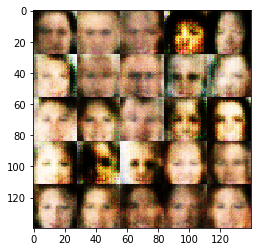

Epoch 1/1... Batch 410... Discriminator Loss: 0.1965... Generator Loss: 2.8606
Epoch 1/1... Batch 420... Discriminator Loss: 0.7320... Generator Loss: 1.4585
Epoch 1/1... Batch 430... Discriminator Loss: 2.6293... Generator Loss: 0.0990
Epoch 1/1... Batch 440... Discriminator Loss: 0.8953... Generator Loss: 3.0092
Epoch 1/1... Batch 450... Discriminator Loss: 0.8558... Generator Loss: 1.7395
Epoch 1/1... Batch 460... Discriminator Loss: 1.0162... Generator Loss: 1.1559
Epoch 1/1... Batch 470... Discriminator Loss: 0.4554... Generator Loss: 2.5880
Epoch 1/1... Batch 480... Discriminator Loss: 0.4592... Generator Loss: 2.8612
Epoch 1/1... Batch 490... Discriminator Loss: 1.3331... Generator Loss: 1.3566
Epoch 1/1... Batch 500... Discriminator Loss: 0.4146... Generator Loss: 3.2184


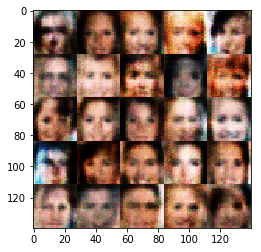

Epoch 1/1... Batch 510... Discriminator Loss: 1.2511... Generator Loss: 1.8039
Epoch 1/1... Batch 520... Discriminator Loss: 0.4253... Generator Loss: 2.6524
Epoch 1/1... Batch 530... Discriminator Loss: 0.3895... Generator Loss: 1.9182
Epoch 1/1... Batch 540... Discriminator Loss: 0.7476... Generator Loss: 1.2204
Epoch 1/1... Batch 550... Discriminator Loss: 2.0088... Generator Loss: 0.2819
Epoch 1/1... Batch 560... Discriminator Loss: 0.7467... Generator Loss: 0.9193
Epoch 1/1... Batch 570... Discriminator Loss: 0.3495... Generator Loss: 3.1319
Epoch 1/1... Batch 580... Discriminator Loss: 1.1273... Generator Loss: 0.6050
Epoch 1/1... Batch 590... Discriminator Loss: 0.2805... Generator Loss: 3.7774
Epoch 1/1... Batch 600... Discriminator Loss: 0.7343... Generator Loss: 0.9174


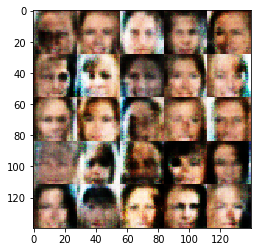

Epoch 1/1... Batch 610... Discriminator Loss: 0.1849... Generator Loss: 3.5084
Epoch 1/1... Batch 620... Discriminator Loss: 0.3012... Generator Loss: 5.1516
Epoch 1/1... Batch 630... Discriminator Loss: 1.0190... Generator Loss: 2.3546
Epoch 1/1... Batch 640... Discriminator Loss: 0.3647... Generator Loss: 1.8047
Epoch 1/1... Batch 650... Discriminator Loss: 2.6790... Generator Loss: 0.1303
Epoch 1/1... Batch 660... Discriminator Loss: 0.3573... Generator Loss: 2.0439
Epoch 1/1... Batch 670... Discriminator Loss: 0.2672... Generator Loss: 2.7637
Epoch 1/1... Batch 680... Discriminator Loss: 1.4101... Generator Loss: 1.0605
Epoch 1/1... Batch 690... Discriminator Loss: 0.5287... Generator Loss: 1.2602
Epoch 1/1... Batch 700... Discriminator Loss: 0.7523... Generator Loss: 1.2721


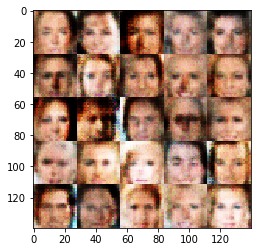

Epoch 1/1... Batch 710... Discriminator Loss: 1.3075... Generator Loss: 0.7873
Epoch 1/1... Batch 720... Discriminator Loss: 0.9635... Generator Loss: 3.7015
Epoch 1/1... Batch 730... Discriminator Loss: 2.1149... Generator Loss: 0.1576
Epoch 1/1... Batch 740... Discriminator Loss: 0.2422... Generator Loss: 4.0660
Epoch 1/1... Batch 750... Discriminator Loss: 0.7016... Generator Loss: 1.1760
Epoch 1/1... Batch 760... Discriminator Loss: 0.3175... Generator Loss: 2.5777
Epoch 1/1... Batch 770... Discriminator Loss: 1.2770... Generator Loss: 2.6062
Epoch 1/1... Batch 780... Discriminator Loss: 0.3271... Generator Loss: 1.8767
Epoch 1/1... Batch 790... Discriminator Loss: 0.4097... Generator Loss: 1.9364
Epoch 1/1... Batch 800... Discriminator Loss: 0.2533... Generator Loss: 2.3780


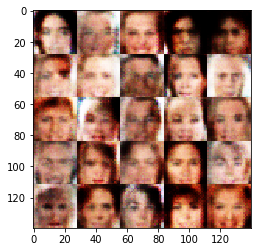

Epoch 1/1... Batch 810... Discriminator Loss: 0.9480... Generator Loss: 0.6341
Epoch 1/1... Batch 820... Discriminator Loss: 0.5102... Generator Loss: 3.6394
Epoch 1/1... Batch 830... Discriminator Loss: 0.5580... Generator Loss: 1.2910
Epoch 1/1... Batch 840... Discriminator Loss: 0.3844... Generator Loss: 1.5662
Epoch 1/1... Batch 850... Discriminator Loss: 0.3255... Generator Loss: 2.0975
Epoch 1/1... Batch 860... Discriminator Loss: 2.1445... Generator Loss: 1.3192
Epoch 1/1... Batch 870... Discriminator Loss: 0.4310... Generator Loss: 1.4749
Epoch 1/1... Batch 880... Discriminator Loss: 0.3401... Generator Loss: 2.0387
Epoch 1/1... Batch 890... Discriminator Loss: 0.3277... Generator Loss: 4.9596
Epoch 1/1... Batch 900... Discriminator Loss: 0.3122... Generator Loss: 2.3918


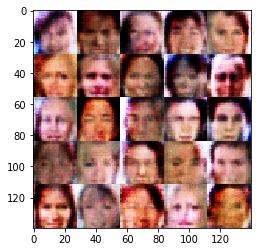

Epoch 1/1... Batch 910... Discriminator Loss: 0.3806... Generator Loss: 2.3994
Epoch 1/1... Batch 920... Discriminator Loss: 1.1903... Generator Loss: 0.5471
Epoch 1/1... Batch 930... Discriminator Loss: 2.2489... Generator Loss: 0.1488
Epoch 1/1... Batch 940... Discriminator Loss: 1.3047... Generator Loss: 0.8228
Epoch 1/1... Batch 950... Discriminator Loss: 0.3403... Generator Loss: 2.0482
Epoch 1/1... Batch 960... Discriminator Loss: 1.6195... Generator Loss: 0.2971
Epoch 1/1... Batch 970... Discriminator Loss: 0.3802... Generator Loss: 1.7479
Epoch 1/1... Batch 980... Discriminator Loss: 0.4356... Generator Loss: 1.5176
Epoch 1/1... Batch 990... Discriminator Loss: 1.9807... Generator Loss: 0.2426
Epoch 1/1... Batch 1000... Discriminator Loss: 0.3560... Generator Loss: 2.2058


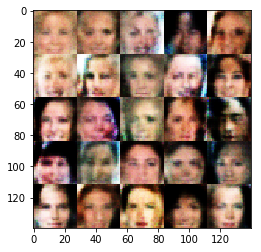

Epoch 1/1... Batch 1010... Discriminator Loss: 0.4341... Generator Loss: 1.6452
Epoch 1/1... Batch 1020... Discriminator Loss: 2.2933... Generator Loss: 0.1334
Epoch 1/1... Batch 1030... Discriminator Loss: 0.3387... Generator Loss: 2.6411
Epoch 1/1... Batch 1040... Discriminator Loss: 0.2340... Generator Loss: 3.2832
Epoch 1/1... Batch 1050... Discriminator Loss: 0.6506... Generator Loss: 5.7178
Epoch 1/1... Batch 1060... Discriminator Loss: 2.2996... Generator Loss: 0.3459
Epoch 1/1... Batch 1070... Discriminator Loss: 0.7246... Generator Loss: 1.2040
Epoch 1/1... Batch 1080... Discriminator Loss: 0.9335... Generator Loss: 0.6690
Epoch 1/1... Batch 1090... Discriminator Loss: 0.3879... Generator Loss: 1.7568
Epoch 1/1... Batch 1100... Discriminator Loss: 1.3548... Generator Loss: 2.3266


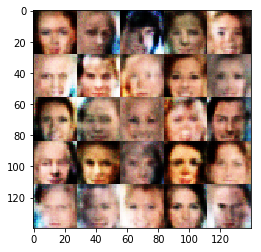

Epoch 1/1... Batch 1110... Discriminator Loss: 2.2659... Generator Loss: 1.7924
Epoch 1/1... Batch 1120... Discriminator Loss: 0.2881... Generator Loss: 3.0041
Epoch 1/1... Batch 1130... Discriminator Loss: 0.3165... Generator Loss: 3.1548
Epoch 1/1... Batch 1140... Discriminator Loss: 0.2213... Generator Loss: 2.6570
Epoch 1/1... Batch 1150... Discriminator Loss: 0.3575... Generator Loss: 1.9975
Epoch 1/1... Batch 1160... Discriminator Loss: 0.4842... Generator Loss: 1.8185
Epoch 1/1... Batch 1170... Discriminator Loss: 0.7492... Generator Loss: 1.0371
Epoch 1/1... Batch 1180... Discriminator Loss: 0.5585... Generator Loss: 1.7694
Epoch 1/1... Batch 1190... Discriminator Loss: 0.2347... Generator Loss: 4.0674
Epoch 1/1... Batch 1200... Discriminator Loss: 2.1836... Generator Loss: 1.1118


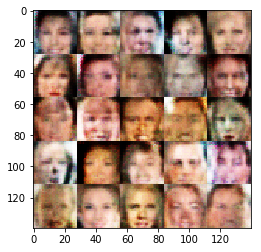

Epoch 1/1... Batch 1210... Discriminator Loss: 0.2849... Generator Loss: 2.2190
Epoch 1/1... Batch 1220... Discriminator Loss: 0.2612... Generator Loss: 3.4557
Epoch 1/1... Batch 1230... Discriminator Loss: 2.6272... Generator Loss: 0.9819
Epoch 1/1... Batch 1240... Discriminator Loss: 0.1918... Generator Loss: 3.5551
Epoch 1/1... Batch 1250... Discriminator Loss: 1.0579... Generator Loss: 0.6392
Epoch 1/1... Batch 1260... Discriminator Loss: 0.7511... Generator Loss: 0.9813
Epoch 1/1... Batch 1270... Discriminator Loss: 1.4963... Generator Loss: 0.3051
Epoch 1/1... Batch 1280... Discriminator Loss: 0.2993... Generator Loss: 2.0940
Epoch 1/1... Batch 1290... Discriminator Loss: 0.6851... Generator Loss: 1.0018
Epoch 1/1... Batch 1300... Discriminator Loss: 0.5760... Generator Loss: 1.1419


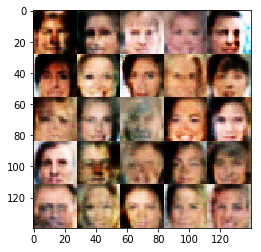

Epoch 1/1... Batch 1310... Discriminator Loss: 0.2116... Generator Loss: 4.3542
Epoch 1/1... Batch 1320... Discriminator Loss: 0.1783... Generator Loss: 4.1182
Epoch 1/1... Batch 1330... Discriminator Loss: 2.2405... Generator Loss: 2.4488
Epoch 1/1... Batch 1340... Discriminator Loss: 1.4040... Generator Loss: 1.4178
Epoch 1/1... Batch 1350... Discriminator Loss: 0.7738... Generator Loss: 1.2248
Epoch 1/1... Batch 1360... Discriminator Loss: 0.7184... Generator Loss: 1.1430
Epoch 1/1... Batch 1370... Discriminator Loss: 0.4007... Generator Loss: 2.4436
Epoch 1/1... Batch 1380... Discriminator Loss: 0.2715... Generator Loss: 2.6586
Epoch 1/1... Batch 1390... Discriminator Loss: 0.2470... Generator Loss: 3.5091
Epoch 1/1... Batch 1400... Discriminator Loss: 0.5049... Generator Loss: 5.0107


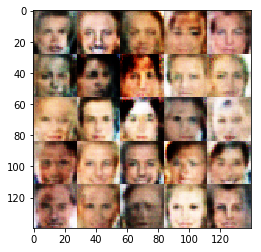

Epoch 1/1... Batch 1410... Discriminator Loss: 0.3588... Generator Loss: 1.6325
Epoch 1/1... Batch 1420... Discriminator Loss: 0.3816... Generator Loss: 1.7012
Epoch 1/1... Batch 1430... Discriminator Loss: 0.3920... Generator Loss: 2.8993
Epoch 1/1... Batch 1440... Discriminator Loss: 2.2063... Generator Loss: 0.1725
Epoch 1/1... Batch 1450... Discriminator Loss: 0.4119... Generator Loss: 1.7759
Epoch 1/1... Batch 1460... Discriminator Loss: 0.7182... Generator Loss: 0.9691
Epoch 1/1... Batch 1470... Discriminator Loss: 1.9853... Generator Loss: 0.2549
Epoch 1/1... Batch 1480... Discriminator Loss: 0.2384... Generator Loss: 4.3415
Epoch 1/1... Batch 1490... Discriminator Loss: 0.3353... Generator Loss: 2.4926
Epoch 1/1... Batch 1500... Discriminator Loss: 0.9502... Generator Loss: 0.6993


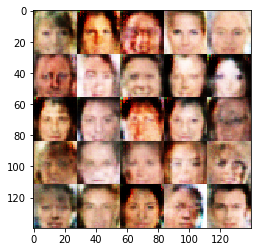

Epoch 1/1... Batch 1510... Discriminator Loss: 0.4107... Generator Loss: 1.7203
Epoch 1/1... Batch 1520... Discriminator Loss: 0.4197... Generator Loss: 2.3690
Epoch 1/1... Batch 1530... Discriminator Loss: 0.9293... Generator Loss: 1.0420
Epoch 1/1... Batch 1540... Discriminator Loss: 1.2992... Generator Loss: 0.9838
Epoch 1/1... Batch 1550... Discriminator Loss: 0.3927... Generator Loss: 1.9876
Epoch 1/1... Batch 1560... Discriminator Loss: 0.6537... Generator Loss: 1.5580
Epoch 1/1... Batch 1570... Discriminator Loss: 0.6684... Generator Loss: 1.1864
Epoch 1/1... Batch 1580... Discriminator Loss: 0.1995... Generator Loss: 2.7475


In [22]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.